In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.constants as const
from sn_companion_collision.sn_collision import kasen, get_filter_trans

from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

from scipy.signal import savgol_filter

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
t_bmax = 58863.34
t_fl = -17.4928

abs_mag_df = pd.read_csv('../plots/abs_mag_p48.csv')

In [8]:
g_ztf = get_filter_trans.get_g_ztf_tc()
r_ztf = get_filter_trans.get_r_ztf_tc()
i_ztf = get_filter_trans.get_i_ztf_tc()

uvm2 = get_filter_trans.get_uvm2_tc()
uvw1 = get_filter_trans.get_uvw1_tc()
uvw2 = get_filter_trans.get_uvw2_tc()

# Ni clumps

Following the method in  Magee & Maguire 2020, we have developed a model with a clump of $^{56}$Ni in the outer ejecta of the SN to see if that can replicate the observations of SN 2019yvq.

In [60]:
spec = pd.read_csv('../data/models/kromer16/specseq25_los.dat', delim_whitespace=True)

new_spec = np.where(spec['0.00'] == 0)
new_spec = np.append(-1, new_spec[0])
N_spec = len(new_spec)

wave = spec['0.00'].iloc[0:255]

In [61]:
t_Ni = spec.columns.values[1:].astype(float)
g_Ni = np.zeros((N_spec, len(t_Ni)))
r_Ni = np.zeros_like(g_Ni)
i_Ni = np.zeros_like(g_Ni)

for spec_num, ns in enumerate(new_spec):

    for t_step, time in enumerate(t_Ni):
        Ni_spec = kasen.Spectrum(spec['0.00'].iloc[ns+1:ns+256], 
                                 spec['{:.2f}'.format(time)].iloc[ns+1:ns+256])
        syn_phot = np.zeros(6)
        for filt_num, filt in enumerate([g_ztf, r_ztf, i_ztf]):
            f_lambda = Ni_spec.SyntheticPhotometry(filt) * 25 # factor of 25 from 25 diff ang bins
            f_nu = f_lambda * filt.wavelength_eff**2/const.c.to('Angstrom/s').value * 1e23
            syn_phot[filt_num] = -2.5*np.log10(f_nu/3631)

        g_Ni[spec_num, t_step] = syn_phot[0]
        r_Ni[spec_num, t_step] = syn_phot[1]
        i_Ni[spec_num, t_step] = syn_phot[2]

### Determine best model and offset

Need to be careful about fitting the early flash, which is not present in Kromer+16 model.

In [69]:
# figure out time offset
t_grid = np.linspace(0,4,101)

chi2_grid = np.zeros((N_spec, len(t_grid)))

for spec_num in range(N_spec):

    for tnum, toff in enumerate(t_grid):

        r_early = np.where((abs_mag_df.filt == 'r') & 
                       (abs_mag_df.t_restframe <= 40 - toff) & 
                       (abs_mag_df.t_restframe > 5.72 - toff))
        g_early = np.where((abs_mag_df.filt == 'g') & 
                           (abs_mag_df.t_restframe <= 40 - toff) & 
                           (abs_mag_df.t_restframe > 5.72 - toff))
        i_early = np.where((abs_mag_df.filt == 'i') & 
                           (abs_mag_df.t_restframe <= 40 - toff) & 
                           (abs_mag_df.t_restframe > 5.72 - toff))


        model = np.interp(abs_mag_df.t_restframe.iloc[r_early], t_Ni - toff, r_Ni[spec_num])
        chi2_grid[spec_num, tnum] += np.sum((abs_mag_df.abs_mag.iloc[r_early].values - model)**2/abs_mag_df.mag_unc.iloc[r_early].values**2)

        model = np.interp(abs_mag_df.t_restframe.iloc[g_early], t_Ni - toff, g_Ni[spec_num])
        chi2_grid[spec_num, tnum] += np.sum((abs_mag_df.abs_mag.iloc[g_early].values - model)**2/abs_mag_df.mag_unc.iloc[g_early].values**2)

        model = np.interp(abs_mag_df.t_restframe.iloc[i_early], t_Ni - toff, i_Ni[spec_num])
        chi2_grid[spec_num, tnum] += np.sum((abs_mag_df.abs_mag.iloc[i_early].values - model)**2/abs_mag_df.mag_unc.iloc[i_early].values**2)

In [143]:
chi2_grid[range(N_spec),np.argmin(chi2_grid, axis=1)]

array([402155.85312287, 669505.22142597, 464191.22174373, 693351.18205471,
       570685.01751664, 221107.92171339, 460622.71099577, 185232.54266194,
       525023.94959765, 256486.24909082, 192430.37068065, 393146.42878216,
       137136.6955984 , 484306.6859033 , 198969.84571573, 217353.46190314,
       448300.18179491, 185517.99733417, 525134.60211111, 258198.31307029,
       382089.34034692, 640585.26231137, 448669.67248643, 671932.51530352,
       558977.1886841 ])

<IPython.core.display.Javascript object>


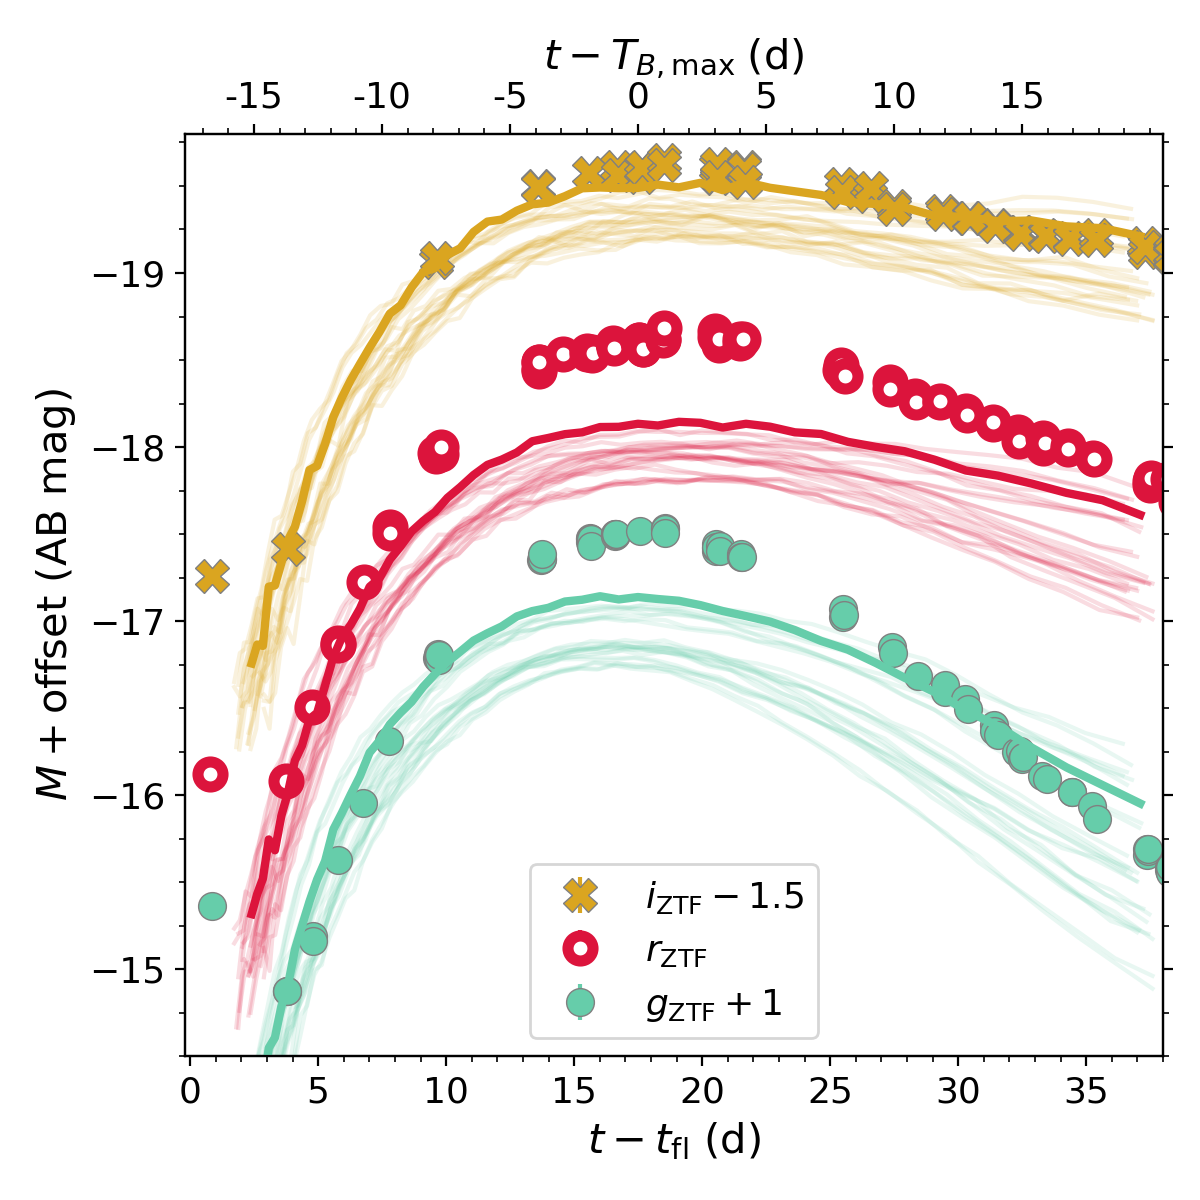

In [131]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 4,
            1: 0.5,
            3: 0.5}
ms_dict = {2: 9,
           1: 10,
           3: 12}
filt_dict = {1:'g', 
             2:'r', 
             3:'i'}
label_dict = {1:r'$g_\mathrm{ZTF} + 1$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF} - 1.5$'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}
offset_dict = {3: -1.5,
               1: 1,
               2: 0,
               "uvw2": 4,
               "uvm2": 2,
               "uvw1": 2}

best_model = np.argmin(chi2_grid[range(N_spec),np.argmin(chi2_grid, axis=1)])

fig, ax = plt.subplots(figsize=(6,6))

for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
# plot VM models
for glc, toff in zip(g_Ni, t_grid[np.argmin(chi2_grid, axis=1)]):
    ax.plot(t_Ni - toff, glc + offset_dict[1], 
            color=color_dict[1], alpha=0.15)
    
ax.plot(t_Ni - t_grid[np.argmin(chi2_grid, axis=1)][best_model], 
        g_Ni[best_model] + offset_dict[1], 
        color=color_dict[1], lw=3, zorder=100)

for rlc, toff in zip(r_Ni, t_grid[np.argmin(chi2_grid, axis=1)]):
    ax.plot(t_Ni - toff, rlc + offset_dict[2], 
            color=color_dict[2], alpha=0.15)
    
ax.plot(t_Ni - t_grid[np.argmin(chi2_grid, axis=1)][best_model], 
        r_Ni[best_model] + offset_dict[2], 
        color=color_dict[2], lw=3, zorder=100)

for ilc, toff in zip(i_Ni, t_grid[np.argmin(chi2_grid, axis=1)]):
    ax.plot(t_Ni - toff, ilc + offset_dict[3], 
            color=color_dict[3], alpha=0.15)
    
ax.plot(t_Ni - t_grid[np.argmin(chi2_grid, axis=1)][best_model], 
        i_Ni[best_model] + offset_dict[3], 
        color=color_dict[3], lw=3, zorder=100)





ax.set_ylim(-14.5, -19.8)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-0.2, 38)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=8, fontsize=13)

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 25, 46) - t_fl))
ax2.tick_params(labelsize=13)


fig.tight_layout()

## Plot light curve and spectra

In [128]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

<IPython.core.display.Javascript object>


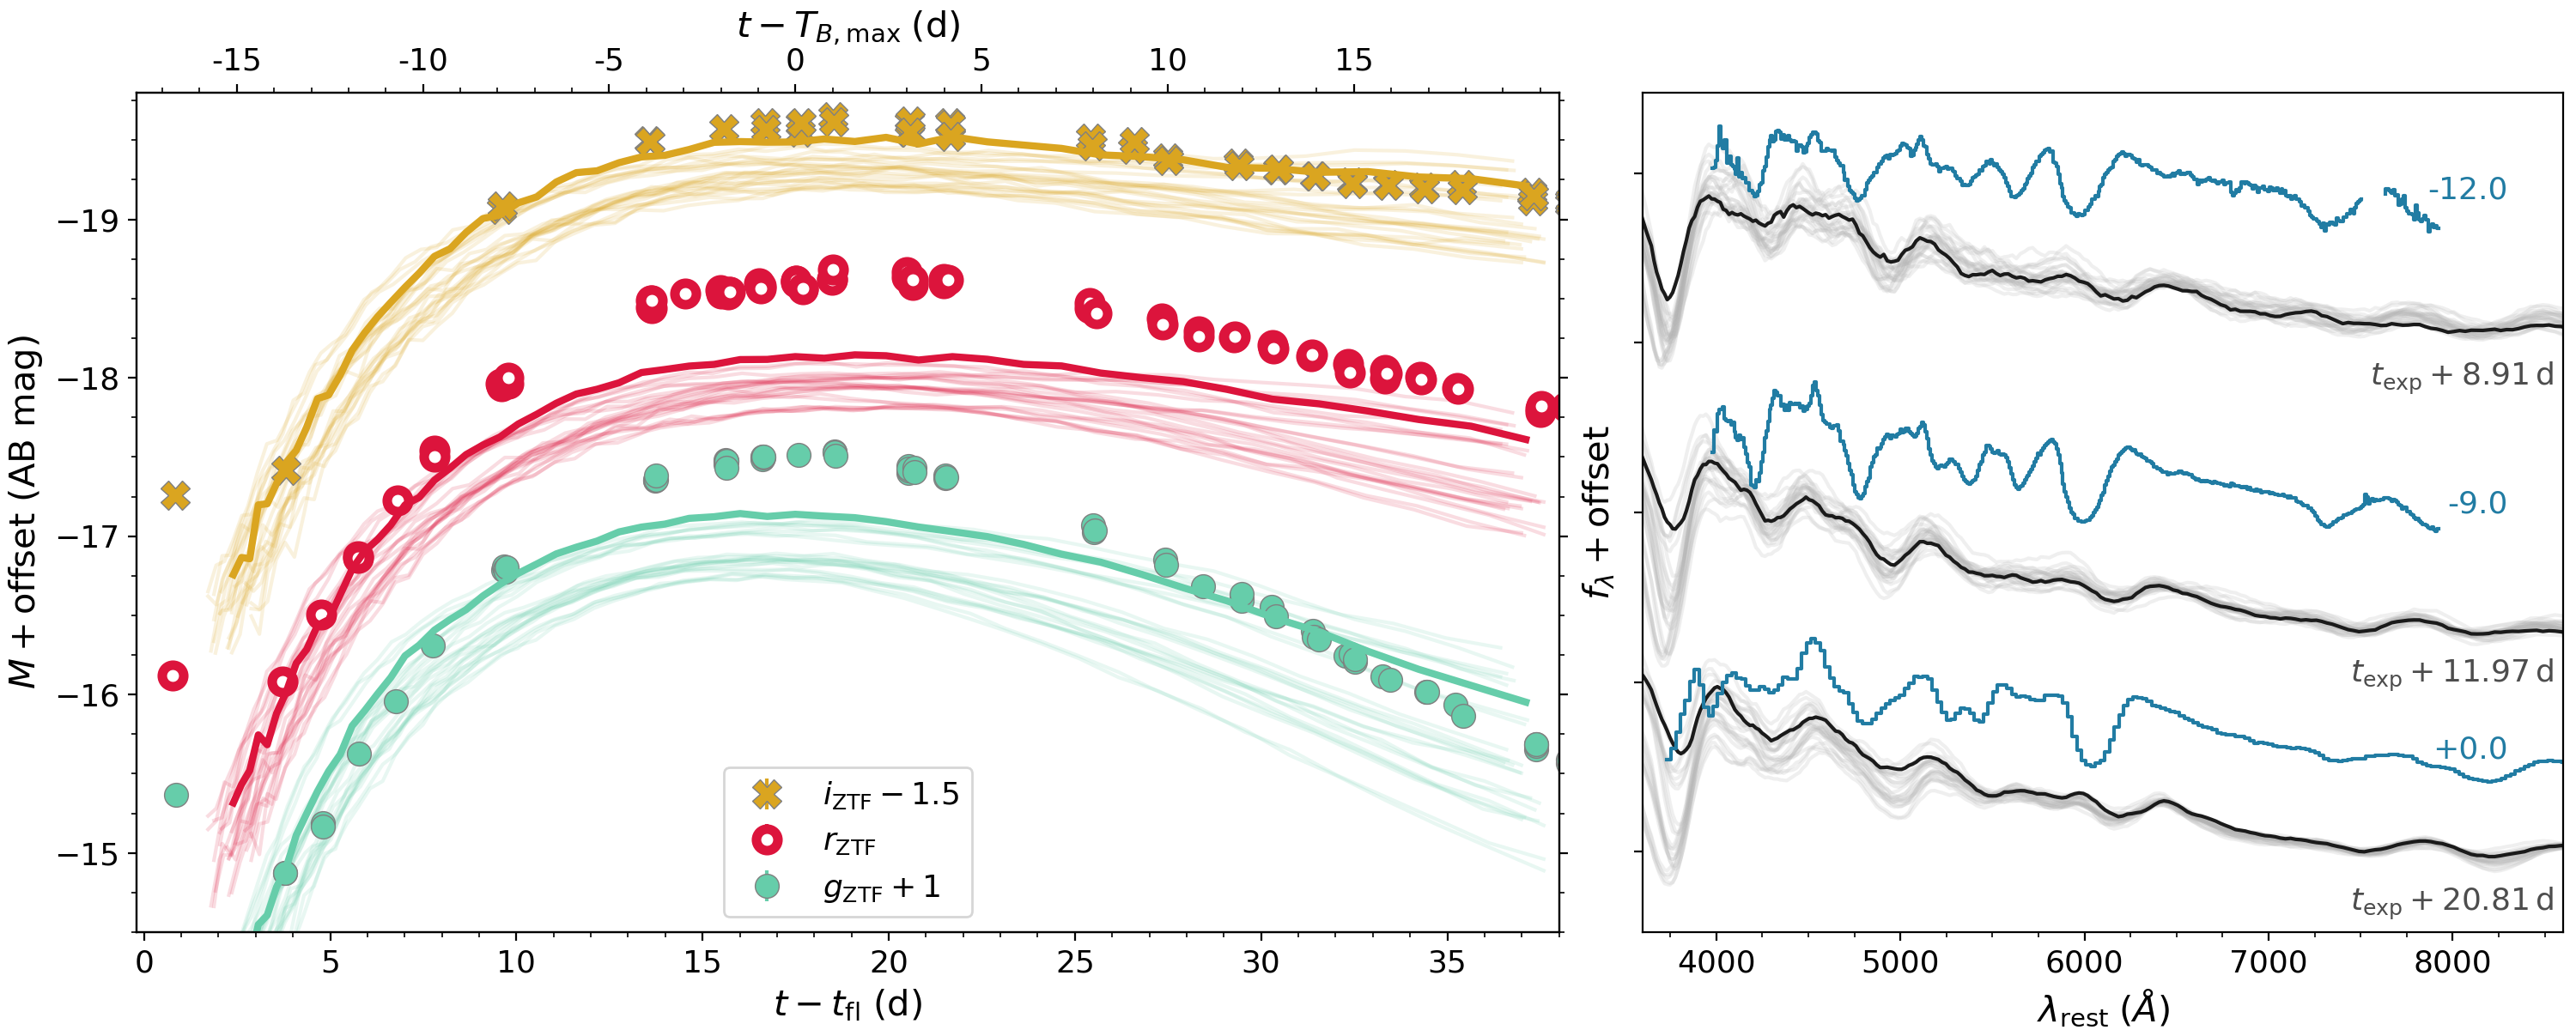

In [140]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig = plt.figure(figsize=(15,6), constrained_layout=True)

gs = GridSpec(1, 5, figure=fig)
ax = fig.add_subplot(gs[:, 0:3])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax_spec = fig.add_subplot(gs[:, 3:])

for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
# plot VM models
for glc, toff in zip(g_Ni, t_grid[np.argmin(chi2_grid, axis=1)]):
    ax.plot(t_Ni - toff, glc + offset_dict[1], 
            color=color_dict[1], alpha=0.15)
    
ax.plot(t_Ni - t_grid[np.argmin(chi2_grid, axis=1)][best_model], 
        g_Ni[best_model] + offset_dict[1], 
        color=color_dict[1], lw=3, zorder=100)

for rlc, toff in zip(r_Ni, t_grid[np.argmin(chi2_grid, axis=1)]):
    ax.plot(t_Ni - toff, rlc + offset_dict[2], 
            color=color_dict[2], alpha=0.15)
    
ax.plot(t_Ni - t_grid[np.argmin(chi2_grid, axis=1)][best_model], 
        r_Ni[best_model] + offset_dict[2], 
        color=color_dict[2], lw=3, zorder=100)

for ilc, toff in zip(i_Ni, t_grid[np.argmin(chi2_grid, axis=1)]):
    ax.plot(t_Ni - toff, ilc + offset_dict[3], 
            color=color_dict[3], alpha=0.15)
    
ax.plot(t_Ni - t_grid[np.argmin(chi2_grid, axis=1)][best_model], 
        i_Ni[best_model] + offset_dict[3], 
        color=color_dict[3], lw=3, zorder=100)





ax.set_ylim(-14.5, -19.8)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-0.2, 38)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=8, fontsize=13)

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 25, 46) - t_fl))
ax2.tick_params(labelsize=13)


# plot the spectra

# 8.91 d after explosion = -12 phase spectrum
# norm_flux = np.median(Llambda[62].T[np.where((wave > 6400) & (wave < 6600))])
# ax_spec.plot(wave, savgol_filter(Llambda[62].T, 21, 2)/norm_flux,
#              '0.3')

for spec_num, ns in enumerate(new_spec):
    wave = spec['0.00'].iloc[ns+1:ns+256]
    norm_flux = np.median(spec['8.91'].iloc[ns+1:ns+256].values[np.where((wave > 6400) & (wave < 6600))])
    ax_spec.plot(wave, savgol_filter(spec['8.91'].iloc[ns+1:ns+256], 21, 2)/norm_flux - 0.3, 
             '0.7', alpha=0.2)

norm_flux = np.median(spec['8.91'].iloc[new_spec[best_model]+1:new_spec[best_model]+256].values[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(spec['0.00'].iloc[new_spec[best_model]+1:new_spec[best_model]+256], 
         savgol_filter(spec['8.91'].iloc[new_spec[best_model]+1:new_spec[best_model]+256], 21, 2)/norm_flux -0.3, 
         '0.1')


spec_file = '../data/spectra/ZTF19adcecwu_20200103_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
plot_blue = np.where(wv < 7585)
ax_spec.plot(wv[plot_blue]/(1+z), fl[plot_blue]/norm_flux + 1, color=aam_colors['blue'])
plot_red = np.where(wv > 7700)
ax_spec.plot(wv[plot_red]/(1+z), fl[plot_red]/norm_flux + 1, color=aam_colors['blue'])

ax_spec.text(8300, 1.7, '-12.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -0.5, r'$t_\mathrm{exp} + 8.91\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 11.97 d after explosion = -9 phase spectrum
for spec_num, ns in enumerate(new_spec):
    wave = spec['0.00'].iloc[ns+1:ns+256]
    norm_flux = np.median(spec['11.97'].iloc[ns+1:ns+256].values[np.where((wave > 6400) & (wave < 6600))])
    ax_spec.plot(wave, savgol_filter(spec['11.97'].iloc[ns+1:ns+256], 21, 2)/norm_flux - 3.9, 
             '0.7', alpha=0.2)

norm_flux = np.median(spec['11.97'].iloc[new_spec[best_model]+1:new_spec[best_model]+256].values[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(spec['0.00'].iloc[new_spec[best_model]+1:new_spec[best_model]+256], 
         savgol_filter(spec['11.97'].iloc[new_spec[best_model]+1:new_spec[best_model]+256], 21, 2)/norm_flux -3.9, 
         '0.1')

# norm_flux = np.median(Llambda[92].T[np.where((wave > 6400) & (wave < 6600))])
# ax_spec.plot(wave, savgol_filter(Llambda[92].T, 21, 2)/norm_flux - 3.9,
#              '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200106_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux -2.5, color=aam_colors['blue'])

ax_spec.text(8300, -2., '-9.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -4., r'$t_\mathrm{exp} + 11.97\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 20.81 d after explosion = +0 phase spectrum
for spec_num, ns in enumerate(new_spec):
    wave = spec['0.00'].iloc[ns+1:ns+256]
    norm_flux = np.median(spec['20.81'].iloc[ns+1:ns+256].values[np.where((wave > 6400) & (wave < 6600))])
    ax_spec.plot(wave, savgol_filter(spec['20.81'].iloc[ns+1:ns+256], 21, 2)/norm_flux  - 6.5, 
             '0.7', alpha=0.2)

norm_flux = np.median(spec['20.81'].iloc[new_spec[best_model]+1:new_spec[best_model]+256].values[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(spec['0.00'].iloc[new_spec[best_model]+1:new_spec[best_model]+256], 
         savgol_filter(spec['20.81'].iloc[new_spec[best_model]+1:new_spec[best_model]+256], 21, 2)/norm_flux - 6.5, 
         '0.1')

spec_file = '../data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux - 5.3, color=aam_colors['blue'])

ax_spec.text(8300, -4.9, '+0.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -6.7, r'$t_\mathrm{exp} + 20.81\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')


ax_spec.set_xlim(3600,8600)
ax_spec.set_yticklabels([])
ax_spec.set_ylabel(r'$f_\lambda + \mathrm{offset}$', fontsize=15)
ax_spec.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$', fontsize=15)
ax_spec.set_ylim(-6.95,2.95)
ax_spec.tick_params(labelsize=13)
ax_spec.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(top=0.91,bottom=0.095,right=0.995,left=0.053)
fig.savefig('../paper/figures/violent_merger.pdf')